# Neural Networks

Neural Networks for regression and classification

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.model_selection import train_test_split

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Import code from src
sys.path.insert(0, '../src/')
from project_tools import fig_path

from neuralnetwork import *
from isingmodel import generate_1Ddata

### Regression

Generate data for 1D Ising-model energy:

In [3]:
# generate data
np.random.seed(42)
L = 40     # system size
N = 10000  # number of points
data, target = generate_1Ddata(L, N)

max_val = np.max(target)

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.96, test_size=0.04)

#independent validation set
X_val, y_val = generate_1Ddata(L, 1000)

#normalize target
y_train /= max_val
y_test /= max_val
y_val /= max_val

print(len(y_train))
print(len(y_test))
print(len(y_val))

(10000, 1600)
(1000, 1600)
9600
400
1000


Grid search for neural network:

In [4]:
def R2(y, y_pred):
    y_mean = np.mean(y)
    return 1 - np.sum((y - y_pred)**2) /np.sum((y - y_mean)**2)

def accuracy(y, y_pred):
    y_pred = np.round(y_pred)
    return np.mean(y == y_pred)

def grid_search_nn(learning_rate, penalty, layers, activ_func, cost, 
                   batch_size, epochs, X_train, y_train, X_val, y_val, accuracy):
    count = 0
    tot_steps = len(learning_rate)*len(penalty)

    models = []
    #training models
    for lr in learning_rate:
        for p in penalty:
            count += 1
            
            models.append(NeuralNetwork(layers, activ_func, cost))
            models[-1].train(X_train, y_train, X_val, y_val, lr, p, batch_size, epochs, accuracy)
            

            sys.stdout.write("\r" + "%d/%d"%(count, tot_steps))
            sys.stdout.flush()
    
    return models

Specify neural network for regression:

In [5]:
tanh = Tanh()
sig = Sigmoid()
relu = Relu()
_pass = Pass()
square_loss = SquareLoss()
np.random.seed(42)

layers = [1600, 400, 1]
activ_func = [tanh, _pass]
cost = square_loss

#learning_rate = [1e-5, 4e-5, 9e-5]
#penalty =       [1e-5, 1e-4, 1e-3]

learning_rate = [7e-5, 9e-5, 1.1e-4]
penalty =       [5e-4, 1e-3, 2e-3]

models = grid_search_nn(learning_rate, penalty, layers, activ_func, cost, 100, 50, X_train, y_train, X_val, y_val, R2)

9/9

Plot R2-score of the various models:

In [7]:
def plot_data(x,y,data,title=None):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{penalty}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()

    plt.show()

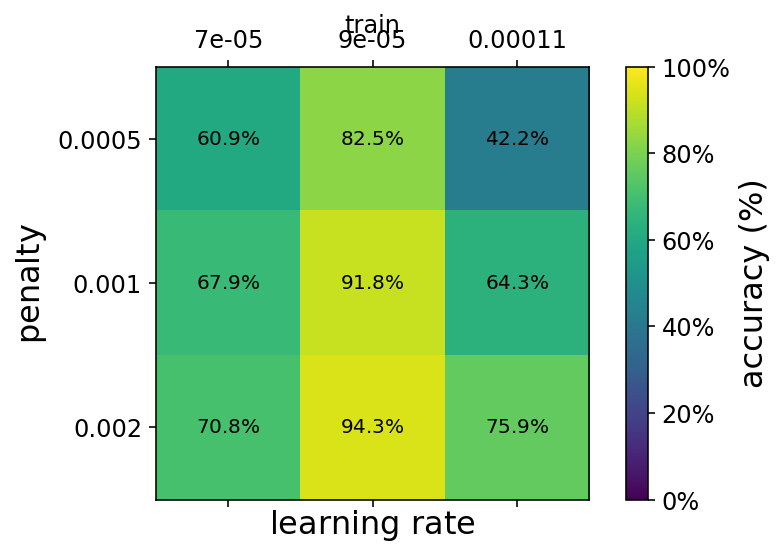

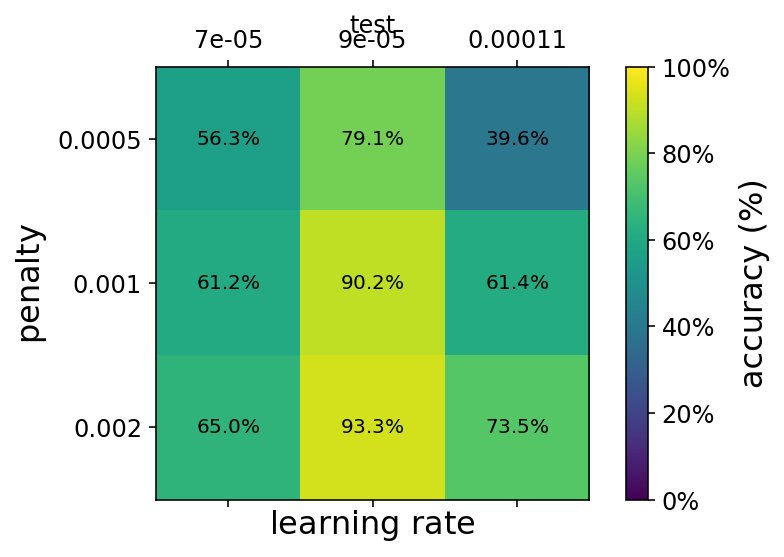

In [8]:
R2_train = []
R2_test = []
for i in range(len(models)):
    y_pred = models[i].predict(X_train)[:,0]
    R2_train.append(R2(y_train, y_pred)) 
    
    y_pred = models[i].predict(X_test)[:,0]
    R2_test.append(R2(y_test, y_pred))
    
R2_train = np.array(R2_train).reshape((3,3))
R2_test = np.array(R2_test).reshape((3,3))

plot_data(learning_rate, penalty, R2_train, title = "train")
plot_data(learning_rate, penalty, R2_test, title = "test")

Determine the connection strength of various models

In [9]:
def plot_connection_strength(model):
    connection_strength = np.sum(np.abs(model.W[0]),axis = 0)
    ave_cs = np.mean(connection_strength)*np.ones(len(connection_strength))

    explanatory_weights = np.array(list(range(1, 1600, 41)) + list(range(40, 1600, 41)))
    ave_ew = np.mean(connection_strength[explanatory_weights])*np.ones(len(explanatory_weights))

    plt.plot(connection_strength, "b-", alpha=0.5, label = "Connection Strength (CS)")
    plt.plot(ave_cs,"b-", lw = 3, label = "_no_legend")
    plt.plot(explanatory_weights, connection_strength[explanatory_weights], 
            "ro", label = "CS of Contributing Features", alpha = 0.8)
    plt.plot(explanatory_weights, ave_ew, "r-", lw = 3, label = "_no_legend")
    plt.legend(loc = "lower left")
    plt.show()

7


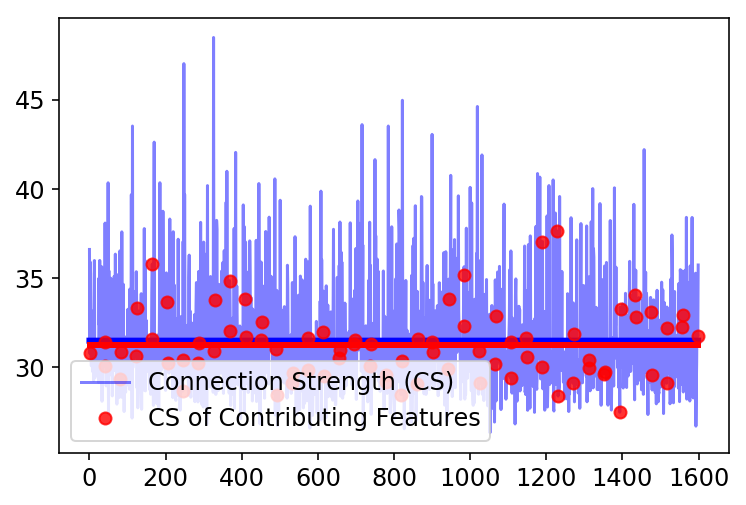

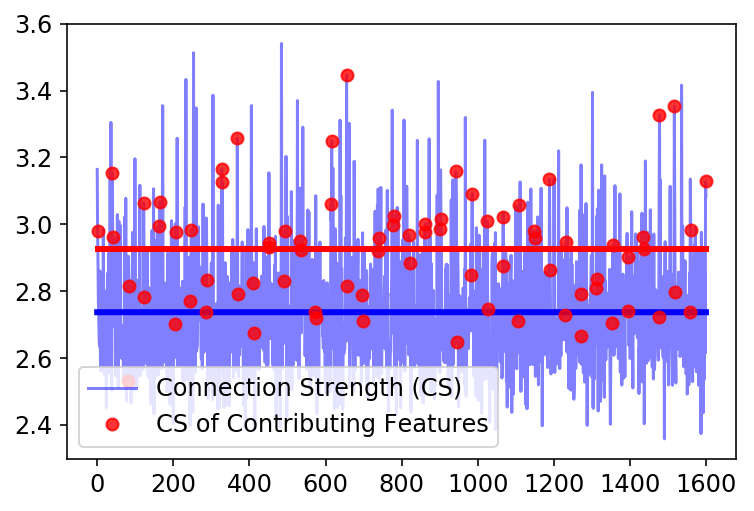

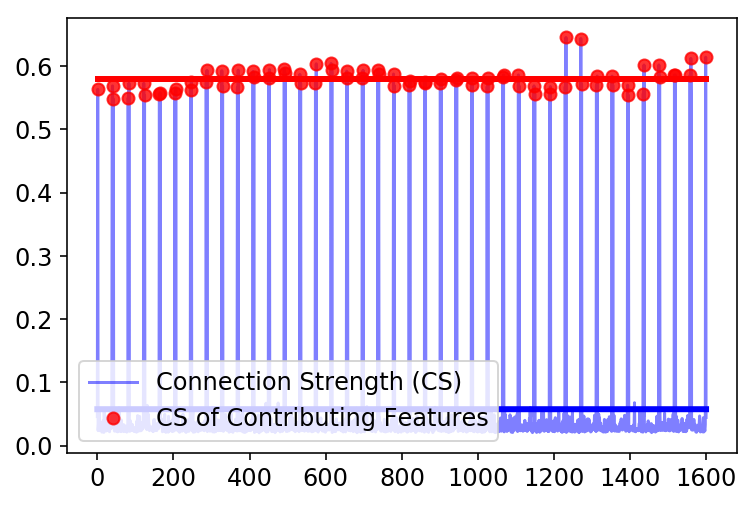

In [10]:
print(np.argmax(R2_test))   
best_model = models[np.argmax(R2_test)]
worst_model = models[np.argmin(R2_test)]

plot_connection_strength(models[6])
plot_connection_strength(models[7])
plot_connection_strength(models[8])

Determine the learning progress of the models

In [11]:
def plot_learning(models, learning_rate, penalty):
    for i in range(len(models)):
        plt.plot(models[i].acc_train[10:])
    
    plt.title("Learning rate = %s"%learning_rate)
    leg = ["R2-score on test, p = %s"%p for p in penalty]
    plt.legend(leg)
    

    plt.grid()
    plt.show()

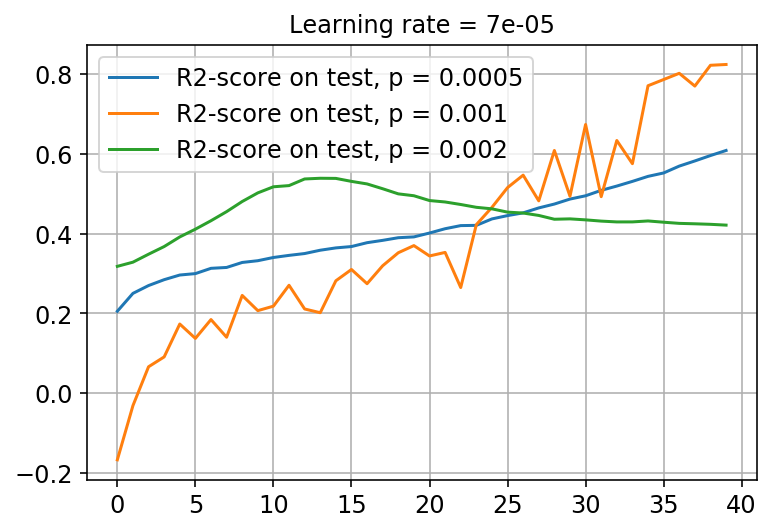

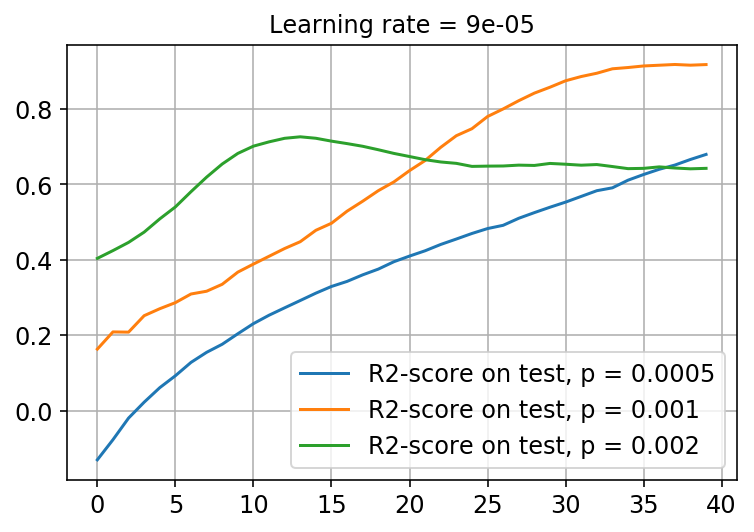

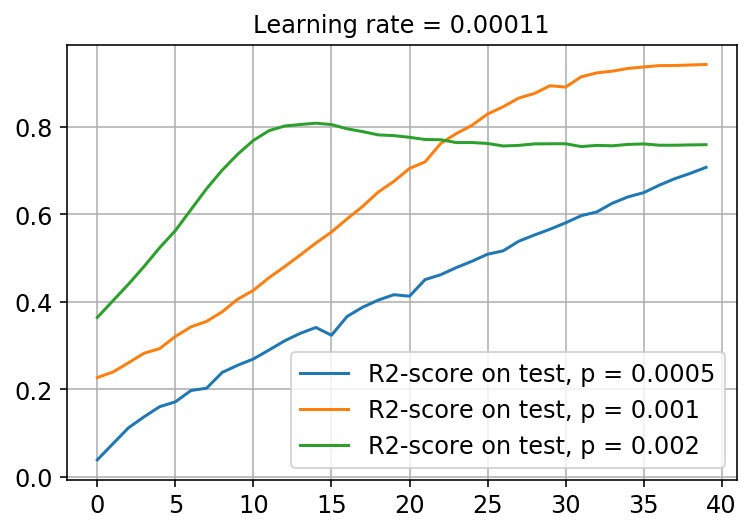

In [12]:
plot_learning(models[0:3], learning_rate[0], penalty)
plot_learning(models[3:6], learning_rate[1], penalty)
plot_learning(models[6:9], learning_rate[2], penalty)

### Classification

Download data and save locally:

In [29]:
url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

labels = pickle.load(urlopen(url_main + label_file_name))

data = pickle.load(urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')

np.save("labels", labels)
np.save("spin_data", data)

del data, labels

Load data

In [30]:
X = np.load("spin_data.npy")
y = np.load("labels.npy")

In [31]:
np.random.seed(42)
# divide data into ordered, critical and disordered
X_ordered=X[:70000,:]
y_ordered=y[:70000]

X_critical=X[70000:100000,:]
y_critical=y[70000:100000]

X_disordered=X[100000:,:]
y_disordered=y[100000:]

# Remove critical, since we only want to train on ordered and disorderes
X=np.concatenate((X_ordered,X_disordered))
y=np.concatenate((y_ordered,y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, test_size=0.1)
X_train, X_val, y_train, y_val =   train_test_split(X_train, y_train, train_size=0.75,test_size=0.25)

print(len(y_train))
print(len(y_test))
print(len(y_val))

39000
13000
13000


Plotting states:

In [32]:
def plot_state(data):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest')
    plt.tight_layout()
    plt.show()

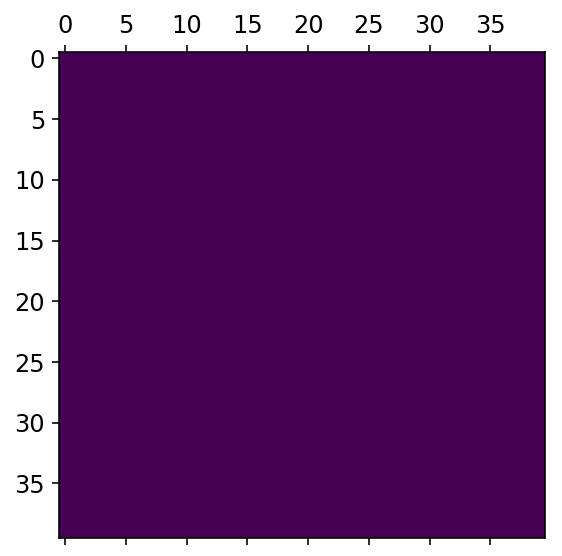

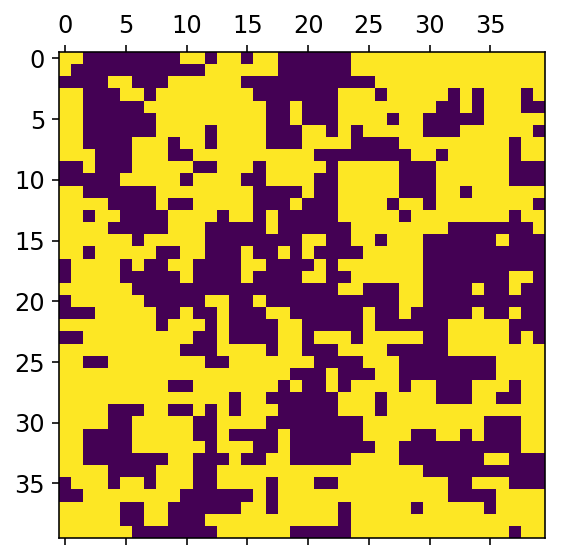

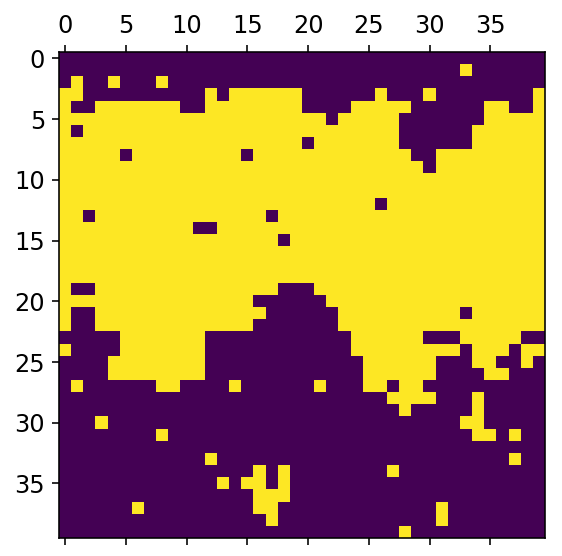

In [33]:
plot_state(X_ordered[0].reshape(40,40))
plot_state(X_disordered[0].reshape(40,40))
plot_state(X_critical[0].reshape(40,40))

Specify the neural network classifier

In [34]:
tanh = Tanh()
sig = Sigmoid()
relu = Relu()
cross_entropy = CrossEntropy()

layers = [1600, 400, 1]
activ_func = [sig, sig]
cost = cross_entropy

learning_rate = [0.00001, 0.00002, 0.00003]
penalty =       [0.00001, 0.0001, 0.001]

np.random.seed(42)
models = grid_search_nn(learning_rate, penalty, layers, activ_func, cost, 100, 50, 
                        X_train, y_train, X_val, y_val, accuracy)

9/9

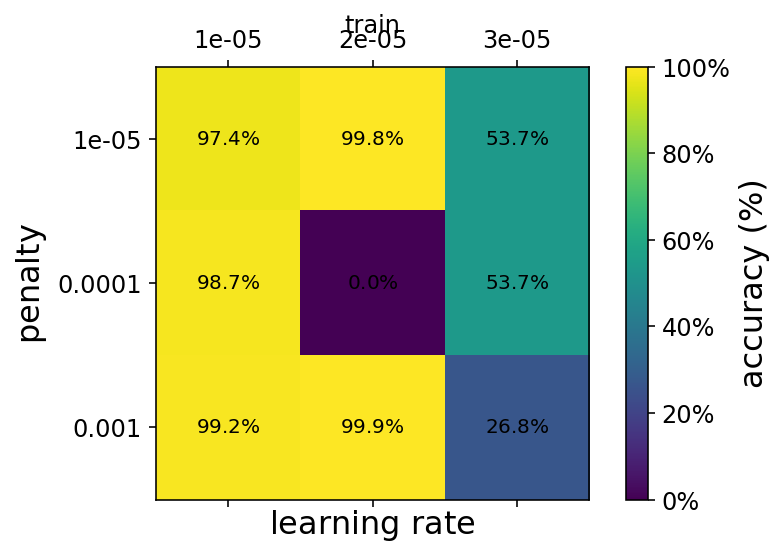

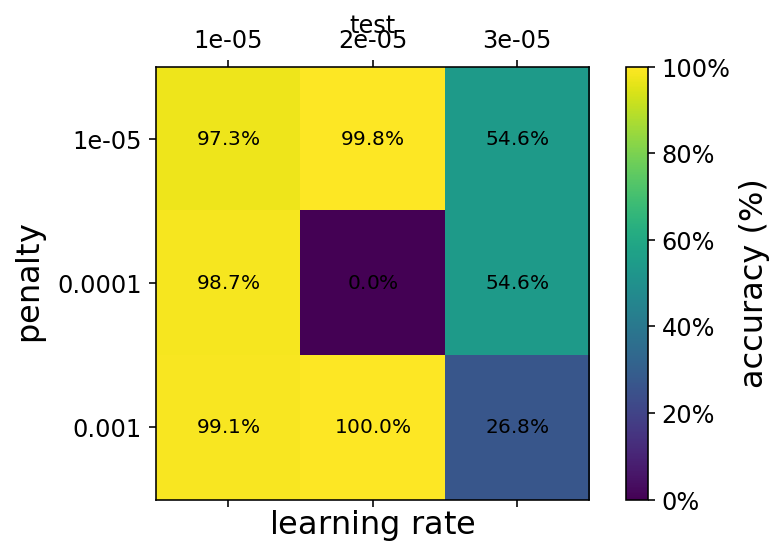

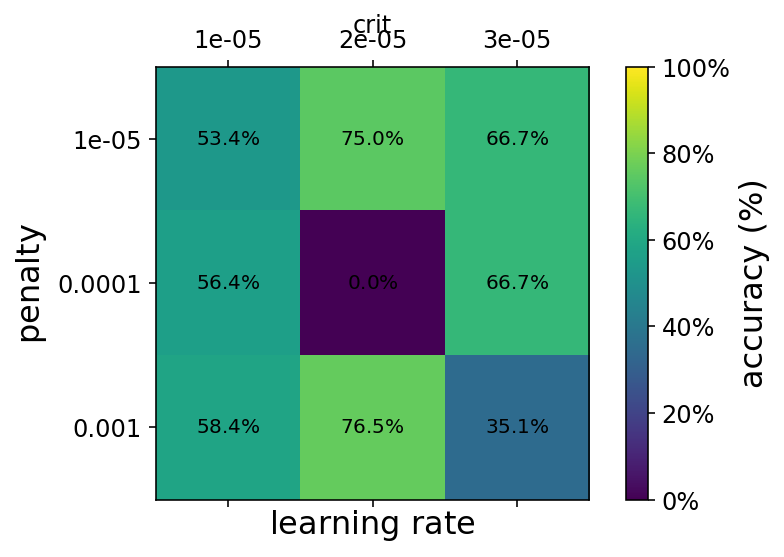

In [35]:
acc_train = []
acc_test = []
acc_crit = []
for i in range(len(models)):
    y_pred = models[i].predict(X_train)[:,0]
    acc_train.append(accuracy(y_train, y_pred)) 
    
    y_pred = models[i].predict(X_test)[:,0]
    acc_test.append(accuracy(y_test, y_pred))
    
    y_pred = models[i].predict(X_critical)[:,0]
    acc_crit.append(accuracy(y_critical, y_pred))
    
acc_train = np.array(acc_train).reshape((3,3))
acc_test = np.array(acc_test).reshape((3,3))
acc_crit = np.array(acc_crit).reshape((3,3))

plot_data(learning_rate, penalty, acc_train, title = "train")
plot_data(learning_rate, penalty, acc_test, title = "test")
plot_data(learning_rate, penalty, acc_crit, title = "crit")

In [36]:
best_model = models[np.argmax(acc_crit)]

y_pred = np.round(best_model.predict(X_critical))[:,0]

wrong_pred = X_critical[(y_critical != y_pred)]
wrong_pred.shape

(7059, 1600)

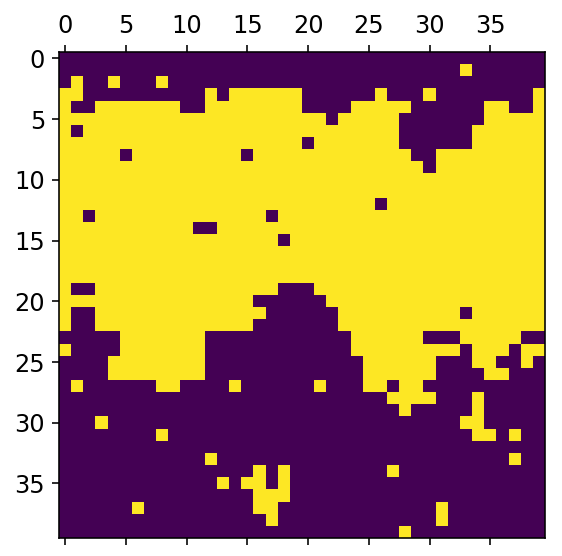

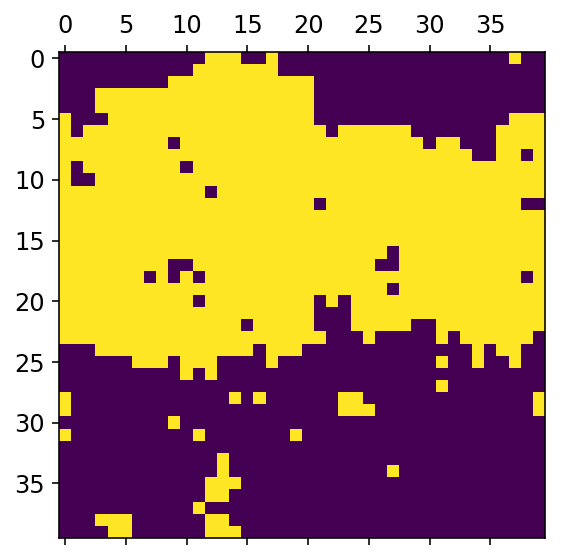

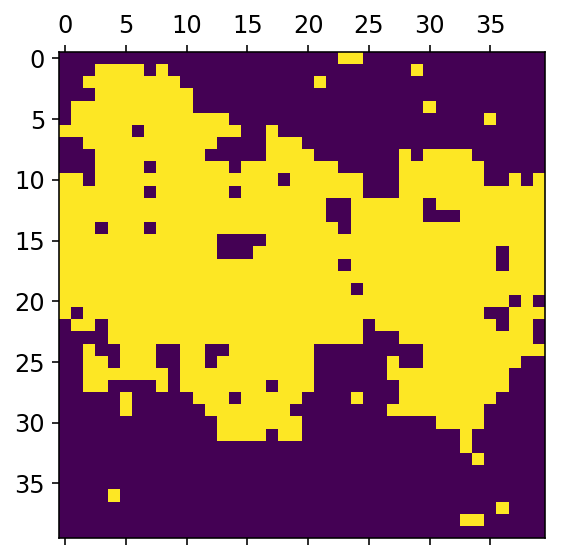

In [37]:
plot_state(wrong_pred[0].reshape(40,40))
plot_state(wrong_pred[1].reshape(40,40))
plot_state(wrong_pred[2].reshape(40,40))

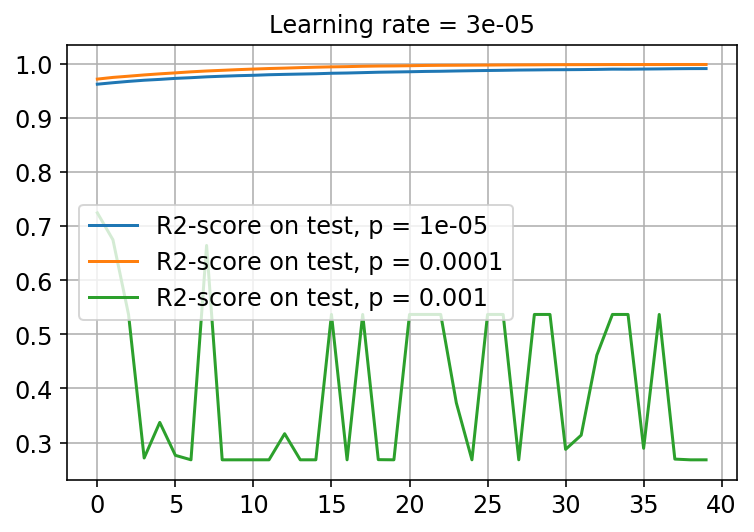

In [38]:
plot_learning(models[6:9], learning_rate[2], penalty)